In [151]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [152]:
def f(x):
    return 3 * x**2 - 4 * x + 5

In [153]:
f(3.0)

20.0

In [154]:
xs = np.arange(start=-5, stop=5, step=0.25)
ys = f(xs)  # element wise application of the function

In [155]:
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

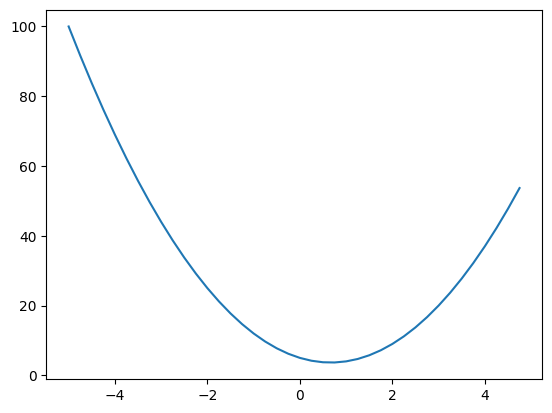

In [156]:
plt.plot(xs, ys)

the derivative of a function $f(x)$ can be defines as
$$
L = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h}
$$
if the limit exists, then the function is differentiable at $x$ and the limit is the derivative of the function at $x$.
We need to understand what the derivate is telling us. Starting from the definition, we can see that we are adding a small quantity $h$ to $x$ and then we are calculating the difference between the function at $x+h$ and the function at $x$.

In [157]:
h = 0.0000001
x = -3.0
print(
    (
        f"f(x): {f(x):4f},"
        f"\nf(x + h): {f(x + h):4f},"
        f"\nf(x+h)-f(x) (total change): {f(x + h) - f(x):4f}"
        f"\nf(x + h) - f(x)/h: {(f(x + h) - f(x)) / h:4f}"
        f"\nf'(x): {(6 * (x + h) - 4):4f}"
    )
)


f(x): 44.000000,
f(x + h): 43.999998,
f(x+h)-f(x) (total change): -0.000002
f(x + h) - f(x)/h: -22.000000
f'(x): -21.999999


In [158]:
a = 2.0
b = -3
c = 10
d = a * b + c
print(d)

4.0


In [159]:
h = 0.0001

a = 2.0  # increasing a will decrease the output till a become negative
b = -3.0
c = 10.0

d1 = a * b + c
# b += h
# a += h
c += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)  # we normalize by h to get the slope

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [160]:
from typing import Union


class Value:
    """ "The building block of the expression graph"""

    def __init__(
        self,
        data: float,
        _children: tuple["Value"] = (),
        _op: str = "",
        label: str = "",
    ) -> None:
        self.data = data
        # grad to keep track of derivative of the output with respect to this value
        self.grad = (
            0.0  # by default we assume that any input does not impact the output
        )
        # the base case is when values are leaves, in that case they do not do a thing
        # in the general case, it is the function that will do the little piece of chain rule
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # in this value object we can have small atomic operations
    # or big complex abstract operations as we need them
    # the only thing that is important here is that
    # we should know how to differentiate that
    # the local derivative
    def __repr__(self) -> str:
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other: Union["Value", float]) -> "Value":
        other = other if isinstance(other, Value) else Value(other)
        out = Value(
            data=self.data + other.data,
            _children=(self, other),
            _op="+",
        )

        # closure to tell the new value how do its local chain rule
        def _backward() -> None:
            # self.grad = 1.0 * out.grad # a bug if self and other are the same
            # other.grad = 1.0 * out.grad
            # add the gradient to previous gradients in case self and other are the same
            # same idea applies to other operations
            # also summing them is how you apply the chain rule in multivariable calculus
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other: Union["Value", float]) -> "Value":
        other = other if isinstance(other, Value) else Value(other)
        out = Value(
            data=self.data * other.data,
            _children=(self, other),
            _op="*",
        )

        # closure to tell the new value how do its local chain rule
        def _backward() -> None:
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other: Union[int, float]) -> "Value":
        # not sure I like this interface, but ok
        assert isinstance(other, (int, float)), (
            "only supporting int/float powers for now"
        )
        out = Value(data=self.data**other, _children=(self,), _op=f"**{other}")

        def _backward() -> None:
            # n*self.data^{n-1} * out.grad
            self.grad += (other * self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def __neg__(self) -> "Value":
        return self * -1

    def __radd__(self, other: Union["Value", float]) -> "Value":
        return self.__add__(other)

    def __sub__(self, other: Union["Value", float]) -> "Value":
        return self + (-other)

    def __rsub__(self, other: Union["Value", float]) -> "Value":
        return other + (-self)

    # to handle cases in which we have float or int * Value
    def __rmul__(self, other: Union["Value", float]) -> "Value":
        return self * other

    def __truediv__(self, other: Union["Value", float]) -> "Value":
        return self * other**-1

    def __rtruediv__(self, other: Union["Value", float]) -> "Value":
        return other * self**-1

    def backward(self) -> None:
        topo = []
        visited = set()

        def topological_sort(v: Value) -> None:
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)

        topological_sort(self)
        self.grad = 1.0
        while topo:
            node = topo.pop()
            node._backward()

    def tanh(self) -> "Value":
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(data=t, _children=(self,), _op="tanh")

        # closure to tell the new value how do its local chain rule
        def _backward() -> None:
            self.grad += (1 - t**2) * out.grad  # 1 - tanh^2(x) * out.grad

        out._backward = _backward
        return out

    def exp(self) -> "Value":
        x = self.data
        out = Value(data=math.exp(x), _children=(self,), _op="exp")

        def _backward() -> None:
            self.grad += out.data * out.grad  # e^x * out.grad

        out._backward = _backward
        return out


In [161]:
from graphviz import Digraph


def trace(root: Value) -> tuple[set[Value], set[tuple[Value, Value]]]:
    """Builds the expression graph, with all its vertices and directed edges."""
    nodes: set[Value] = set()
    edges: set[tuple[Value, Value]] = set()

    def dfs_build(v: Value) -> None:
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                dfs_build(child)

    dfs_build(root)
    return nodes, edges


def draw_dot(root: Value, format: str = "svg", rankdir: str = "LR") -> Digraph:
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ["LR", "TB"]
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={"rankdir": rankdir})
    # build all the nodes for the visualization
    for n in nodes:
        dot.node(
            name=str(id(n)),
            label=f"{{ {n.label} | data {n.data:.4f} | grad {n.grad:.4f}}}",
            shape="record",
        )
        if n._op:  # if the node was produce by an operation,
            # we add a node to the visualization to represented
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    # building the edges in the visualization
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [162]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d * f
L.label = "L"
print(d)
print(d._prev)  # the values directly forming the d
print(d._op)

Value(data=4.0, grad=0.0)
{Value(data=10.0, grad=0.0), Value(data=-6.0, grad=0.0)}
+


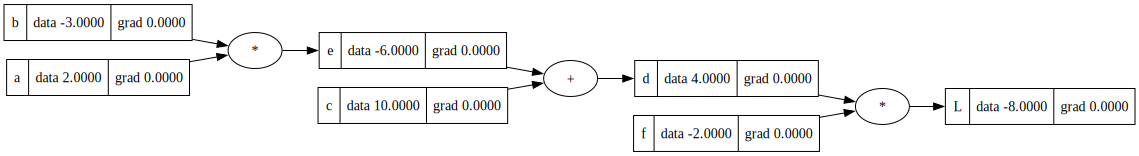

In [163]:
draw_dot(L)

$$
 L = d \cdot f
$$
$$
 \frac{\partial L}{\partial d} = f
$$
proving it
$$
L = \lim_{h \to 0} \frac{g(x+h) - g(x)}{h}
$$
$$
L = \lim_{h \to 0} \frac{df + hf - df}{h} 
$$
$$
L = \lim_{h \to 0} \frac{hf}{h}
$$
$$
L = \lim_{h \to 0} f = f
$$
Equivalently, the $\frac{\partial L}{\partial f}$ would be $d$.

an important one: what is $\frac{\partial L}{\partial c}$?
$$
\frac{\partial L}{\partial c} = \frac{\partial L}{\partial L} \cdot \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial c}
$$
in simpler words, as we know how a change on L affects L, and we know how a change on d affects L, we can calculate how a change on c affects L by chaining them (this is the chain rule by the way)

for the sum we know that if we have $z=a+b$ then $\frac{\partial z}{\partial a} = 1 = \frac{\partial z}{\partial b}$ 

we can see that using the definition of the derivative and expanding
$$
L = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h}
$$
$$
L = \lim_{h \to 0} \frac{((a+h)+b) - (a + b)}{h} = 1
$$
by symmetry, we can see that $\frac{\partial L}{\partial a} = 1 = \frac{\partial L}{\partial b}$

So, each node knows its local influence. It know the derivatives of its output with respect to its inputs.

### chain rule remainder
The chain rule is a way to calculate the derivative of a composition of functions. If we have $z = f(y)$ and $y = f(x)$ then $\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} \cdot \frac{\partial y}{\partial x}$

Citing wikipedia "Intuitively, the chain rule states that knowing the instantaneous rate of change of $z$ relative to $y$ and that of $y$ relative to $x$ allows one to calculate the instantaneous rate of change of z relative to x as the product of the two rates of change.

As put by George F. Simmons: "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."
"

In [164]:
# manual backpropagation :D
L.grad = 1
d.grad = f.data * L.grad
f.grad = d.data * L.grad
c.grad = d.grad * 1
e.grad = d.grad * 1
b.grad = a.data * e.grad
a.grad = b.data * e.grad

In [165]:
# if we wanted to increase L we can just increase each node in the direction of it gradient
# a little step
step = 0.01
a.data += step * a.grad
b.data += step * b.grad
c.data += step * c.grad
d.data += step * d.grad
f.data += step * f.grad
e.data += step * e.grad


In [166]:
# update the value of L based on new define values of a, b, c, d, e, f
# forward pass
e = a * b
e.label = "e"
d = e + c
d.label = "d"
L = d * f
L.label = "L"

in the computation graph, each leaf node is an input variable and each internal node is a function of its children. 

The root node is the output of the function. 

The derivative of the function with respect to a leaf node is the partial derivative of the function with respect to that leaf node.

In [167]:
def a_numerical_approx() -> None:
    h = 0.0001
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"

    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    L1 = d * f
    L1.label = "L1"
    # adding h to one of the values will efectively
    # compute an approximation of the partial derivative
    a = Value(2.0, label="a")
    # a.data += h
    b = Value(-3.0, label="b")
    # b.data += h
    c = Value(10.0, label="c")
    # c.data += h
    e = a * b
    e.label = "e"
    # e.data += h
    d = e + c
    d.label = "d"
    # d.data += h
    f = Value(-2.0, label="f")
    # f.data +=h
    L2 = d * f
    L2.label = "L2"
    # L2.data += h #changing the output a bit, derivative of L with respect to itself is 1

    print((L2.data - L1.data) / h)


a_numerical_approx()

0.0


# Back propagating through a neuron

Real neurons are complicated devices
<img src="img/neuron.jpeg" width="400">
### a Neuron a mathematical model
<img src="img/neuron_model.jpeg" width="400">

we have inputs $x$ and weights $w$ (they act like synapses) and a bias $b$ (that act as the inner happiness of the cell). Inside the cell body we have a $ z = (\sum_i w_ix_i)+b$ and an activation function $f(z)$, this one is usually an squashing function like the sigmoid, relu or the tanh.

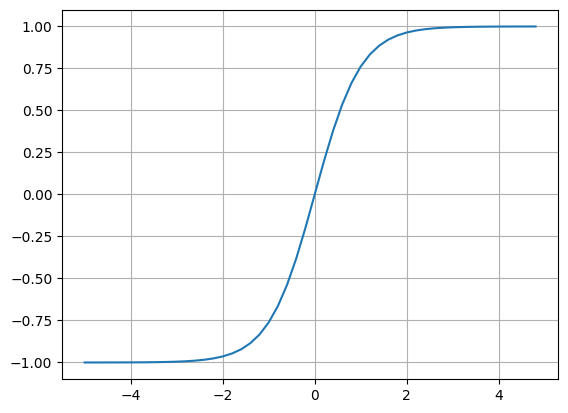

In [168]:
xs = np.arange(start=-5, stop=5, step=0.2)
plt.plot(xs, np.tanh(xs))
plt.grid()
# as xs go closer to 0 their corresponding ys go to cero to,
# if not, they go to 1 or -1

In [169]:
#  two inputs, x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735870195432, label="b")

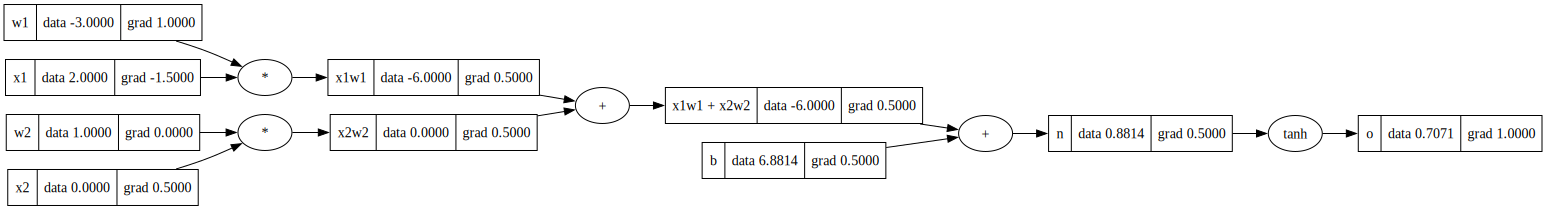

In [170]:
# forward pass
x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b
# is the raw sum of inputs, weights and bias
n.label = "n"

# output
o = n.tanh()
o.label = "o"
# graph the net
o.backward()
draw_dot(o)

In [171]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735870195432, label="b")

In [172]:
# forward pass
x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b
# is the raw sum of inputs, weights and bias
n.label = "n"

# output
# o = tanh(n)
e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.label = "o"

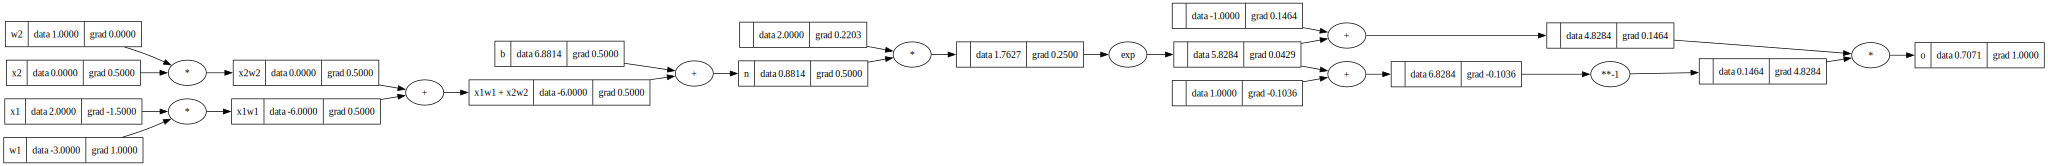

In [173]:
# graph the net
o.backward()
draw_dot(o)

what have we done so far? we have built a computational graph for the neuron. 
also we have define a way for each value to know how it affects the output of the function.
aka we have define the local behavior of each operation in the graph to perform chain rule.

Nevertheless, as a directed graph, we see that we need to call backwards in order of dependencies. First the gradients of the output and then the gradients of the inputs.
we can use topological sort to call the nodes._backwards() in the right order.

## how to do this in pytorch?
minigrad is based on scalar values, so we need to define the operations for scalar values.
pytorch is based on tensors, so we need to define the operations for tensors. 
Nonetheless, the idea is the same. We need to define the operations and the gradients of the operations.

In [174]:
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True

w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Pytorch also handle the backwards as we do it here in micrograd
obviously, pytorch is much more complex and has a lot of optimizations and features that we are not covering here.

In [175]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

# Now what, how do I build a neural network?

we will match the api of pytorch

In [176]:
import random


class Neuron:
    def __init__(self, nin: int) -> None:
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x: list) -> Value:
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self) -> list[Value]:
        return self.w + [self.b]


class Layer:
    def __init__(self, nin: int, nout: int) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self) -> list[Value]:
        return [param for n in self.neurons for param in n.parameters()]


class MLP:
    def __init__(self, nin: int, nouts: list[int]) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x: list) -> list[Value]:
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self) -> list[Value]:
        return [param for layer in self.layers for param in layer.parameters()]

In [177]:
x = [2.0, 3.0]
n = Neuron(2)
print(n(x))


x = [2, 3]
n = Layer(2, 3)
print(n(x))


Value(data=-0.9772111705143761, grad=0.0)
[Value(data=0.9691597540431011, grad=0.0), Value(data=-0.977313385059296, grad=0.0), Value(data=-0.6817740894261621, grad=0.0)]


<img src="img/neural_net2.jpeg" width="400">
lets replicate this model

In [178]:
x = [2, 3]
n = MLP(nin=3, nouts=[4, 4, 1])
o = n(x)


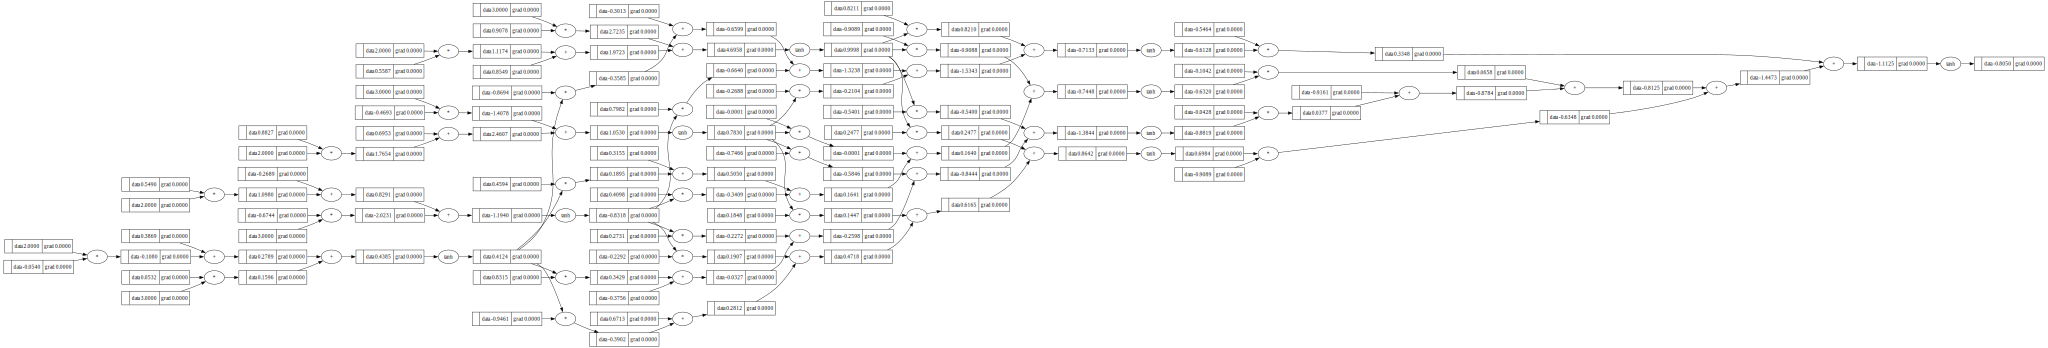

In [179]:
draw_dot(o)

## faking a dataset


In [180]:
xs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0]  # targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.9177755669583789, grad=0.0),
 Value(data=-0.9187290183906442, grad=0.0),
 Value(data=-0.9532831353800605, grad=0.0)]

how do we make so that the neural network learns to predict the output?
we use a function that measures how far the prediction is from the real value. This is called the loss function.
putting that at the end of the computational graph, we can calculate the gradients of the loss with respect to the weights and the bias. Then used those gradients to update the weights and the bias.

In [181]:
# mse loss

ypred = [n(x) for x in xs]
loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=3.6866505631141977, grad=0.0)

In [189]:
# mse loss

ypred = [n(x) for x in xs]
loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=3.6411237029921244, grad=0.0)

In [182]:
loss.backward()

In [183]:
n.layers[0].neurons[0].w[0]

Value(data=-0.05400105304006164, grad=-0.7294208576194869)

In [186]:
# draw_dot(loss)

In [190]:
len(n.parameters())

41

In [187]:
step = 0.01
for p in n.parameters():  # go in the oposite direction of the gradient
    p.data += -step * p.grad

In [188]:
n.layers[0].neurons[0].w[0]

Value(data=-0.046706844463866776, grad=-0.7294208576194869)

# the training loop
for each epoch
    for each batch
        forward pass
        calculate the loss
        backward pass
        update the weights
    calculate the accuracy

In [196]:
# using
xs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0]  # targets
n = MLP(nin=3, nouts=[4, 4, 1])
# training loop
epochs = 100
learning_rate = 0.01

In [199]:
for epoch in range(epochs):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])
    # before backward pass, zero all the gradients
    for p in n.parameters():
        p.grad = 0.0
    # backward pass
    loss.backward()
    # update the parameters
    for p in n.parameters():
        p.data += -learning_rate * p.grad
    print(f"epoch {epoch}, loss {loss.data}")


ypred = [n(x) for x in xs]
ypred

epoch 0, loss 0.07129252448335208
epoch 1, loss 0.07059079993032709
epoch 2, loss 0.06990160003463375
epoch 3, loss 0.06922461043628134
epoch 4, loss 0.06855952676698011
epoch 5, loss 0.06790605427076103
epoch 6, loss 0.0672639074411634
epoch 7, loss 0.06663280967417812
epoch 8, loss 0.06601249293618407
epoch 9, loss 0.06540269744614982
epoch 10, loss 0.06480317137141339
epoch 11, loss 0.06421367053639312
epoch 12, loss 0.06363395814360788
epoch 13, loss 0.06306380450642754
epoch 14, loss 0.06250298679299669
epoch 15, loss 0.06195128878080823
epoch 16, loss 0.061408500621428615
epoch 17, loss 0.060874418614902545
epoch 18, loss 0.06034884499338915
epoch 19, loss 0.05983158771360442
epoch 20, loss 0.05932246025766634
epoch 21, loss 0.05882128144195958
epoch 22, loss 0.05832787523365594
epoch 23, loss 0.05784207057454496
epoch 24, loss 0.057363701211844795
epoch 25, loss 0.056892605535684586
epoch 26, loss 0.056428626422957644
epoch 27, loss 0.05597161108726618
epoch 28, loss 0.055521410

[Value(data=0.8729476306494098, grad=0.0),
 Value(data=-0.9215933774422709, grad=0.0),
 Value(data=-0.888478099134776, grad=0.0)]